In [1]:
library(muhaz)
library(tidyverse)
library(lubridate)
library(knitr)
library(survival)
library(dplyr)
library(ggplot2)
library(purrr)
library(viridis)

Warning message:
"package 'muhaz' was built under R version 4.4.3"
Warning message:
"package 'tidyverse' was built under R version 4.4.3"
Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'readr' was built under R version 4.4.3"
Warning message:
"package 'forcats' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'viridis' was built under R version 4.4.3"
Loading required package: viridisLite



---
# Data Cleaning

In [2]:
# https://data.sciencespo.fr/dataset.xhtml?persistentId=doi:10.21410/7E4/RDAG3O
bhht <- read.csv("../cross-verified-database.csv.gz")
# bhht <- read.csv("bhht_small.csv.gz")

bhht %>% colnames %>% sort

[1] "all_geography_groups"     "approx_birth"            
 [3] "approx_death"             "area1_of_rattachment"    
 [5] "area2_of_rattachment"     "bigperiod_birth"         
 [7] "bigperiod_birth_graph_b"  "bigperiod_death"         
 [9] "bigperiod_death_graph_b"  "birth"                   
[11] "birth_estimation"         "birth_max"               
[13] "birth_min"                "bpla1"                   
[15] "bplo1"                    "citizenship_1_b"         
[17] "citizenship_2_b"          "curid"                   
[19] "death"                    "death_estimation"        
[21] "death_max"                "death_min"               
[23] "dpla1"                    "dplo1"                   
[25] "freq_main_occ"            "freq_second_occ"         
[27] "gender"                   "group_wikipedia_editions"
[29] "level1_main_occ"          "level2_main_occ"         
[31] "level2_second_occ"        "level3_all_occ"          
[33] "level3_main_occ"          "list_areas_of_rattach"   
[35] "list_wikipedia_editions"  "name"                    
[37] "non_missing_score"        "number_wiki_editions"    
[39] "pantheon_1"               "ranking_visib_5criteria" 
[41] "string_citizenship_raw_d" "sum_visib_ln_5criteria"  
[43] "total_count_words_b"      "total_noccur_links_b"    
[45] "un_region"                "un_subregion"            
[47] "updated_death_date"       "wiki_readers_2015_2018"  
[49] "wikidata_code"

## Filter to past 100 years

In [3]:
current_year <- 2025
cutoff_year  <- 1925

bhht_clean <- bhht %>%
mutate(
# Convert to integers
  birth = as.integer(birth),
  death = as.integer(death),
  death_min = as.integer(death_min),
  death_max = as.integer(death_max),
  updated_death_year = suppressWarnings(year(ymd(updated_death_date))),

  # Choose best death year
  death_best = coalesce(updated_death_year, death, death_min, death_max),

  # Impute censoring for plausible living people
  death_final = case_when(
    !is.na(death_best) ~ death_best,
    birth >= cutoff_year ~ current_year,
    TRUE ~ NA_integer_
  ),

  birth_decade = floor(birth / 10) * 10,
  death_decade = floor(death_final / 10) * 10,

  status = if_else(!is.na(death_best), 1L, 0L),

  survival_time_age = death_final - birth,
  survival_time_year = death_final - cutoff_year

) %>%
  filter(
  !is.na(death_final),
  !is.na(birth),
  survival_time_age > 0,
  survival_time_age <= 122,
  # number_wiki_editions > 1,  # reliable?
  death_final >= cutoff_year # alive in last 100 years
) 


bhht_clean %>% dim

[1] 1726675      57

In [4]:
# America first baby
bhht_clean$un_region <- factor(bhht_clean$un_region)
bhht_clean$un_region <- relevel(bhht_clean$un_region, ref = "America")

In [5]:
total_records <- nrow(bhht)
subset_records <- nrow(bhht_clean)

cat("Total records:", total_records, "\n")
cat("Subset records after cleaning:", subset_records, "\n")
cat("Proportion retained:", round(subset_records / total_records, 4) * 100, "%\n")

Total records: 2291817 
Subset records after cleaning: 1726675 
Proportion retained: 75.34 %


---
# EDA

In [6]:
bhht_clean$survival_time_age %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   48.00   66.00   63.67   79.00  122.00 

In [7]:
# Lifespan summaries
summary(bhht_clean$survival_time_age)
summary(bhht_clean$survival_time_year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   48.00   66.00   63.67   79.00  122.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   73.00  100.00   83.08  100.00  100.00 

In [8]:
table(bhht_clean$status)
# Proportion censored
prop.table(table(bhht_clean$status))


      0       1 
1065101  661574 


        0         1 
0.6168509 0.3831491 

In [9]:
bhht_clean %>%
    group_by(gender) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("Gender", "Number of People"), caption = "Number of People per Gender")



Table: Number of People per Gender

|Gender | Number of People|
|:------|----------------:|
|Male   |          1405521|
|Female |           319850|
|       |              792|
|Other  |              512|

In [10]:
bhht_clean %>%
    group_by(un_region) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Region", "Number of People"), caption = "Number of People per UN Region")



Table: Number of People per UN Region

|UN Region | Number of People|
|:---------|----------------:|
|Europe    |           904846|
|America   |           509541|
|Asia      |           169631|
|Oceania   |            67852|
|Africa    |            55214|
|          |            19591|

In [11]:
bhht_clean %>%
    group_by(un_subregion) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Subregion", "Number of People"), caption = "Number of People per UN Subregion")



Table: Number of People per UN Subregion

|UN Subregion                        | Number of People|
|:-----------------------------------|----------------:|
|Western Europe                      |           542044|
|Northern America                    |           378767|
|Southern Europe                     |           158629|
|Northern Europe                     |           111901|
|South America                       |            94379|
|Eastern Europe                      |            92272|
|Oceania Western World               |            66241|
|Eastern Asia                        |            59780|
|South Asia incl. Indian Peninsula   |            46187|
|Western Asia (Middle East Caucasus) |            39053|
|Central America                     |            24227|
|SouthEast Asia                      |            20861|
|                                    |            19591|
|West Africa                         |            15900|
|North Africa                        |      

## Distribution of Covariates

In [12]:
# Determine number of bins for histograms
num_bins <- bhht_clean$survival_time_age %>% unique() %>% length() / 4
num_bins <- ceiling(num_bins)
print(num_bins)

palette <- scale_fill_brewer(palette = "Set1")

[1] 31


### Distribution by Gender

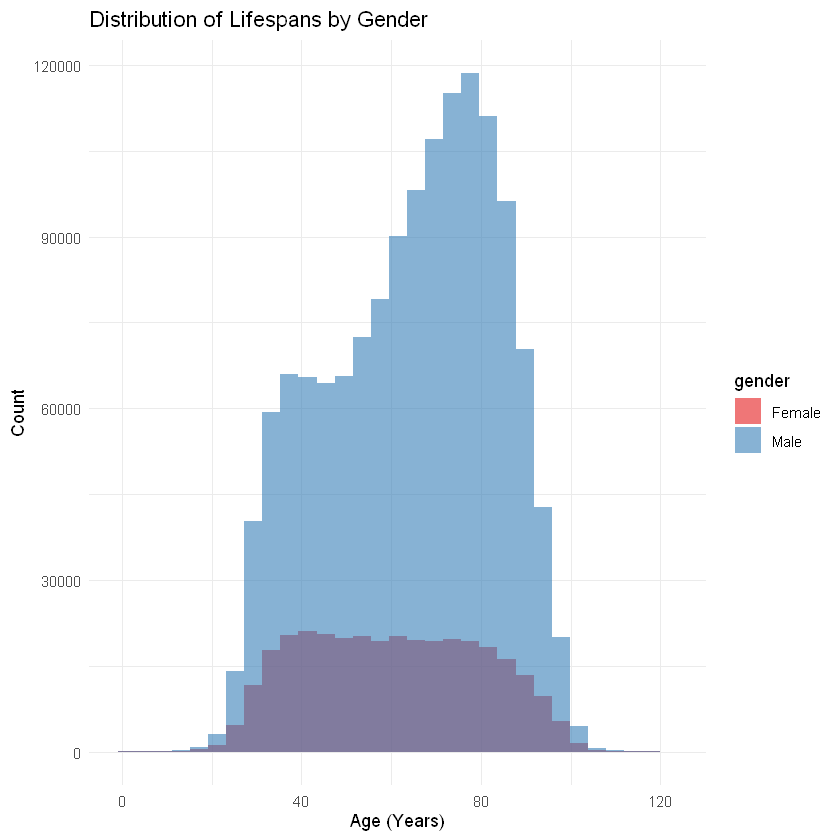

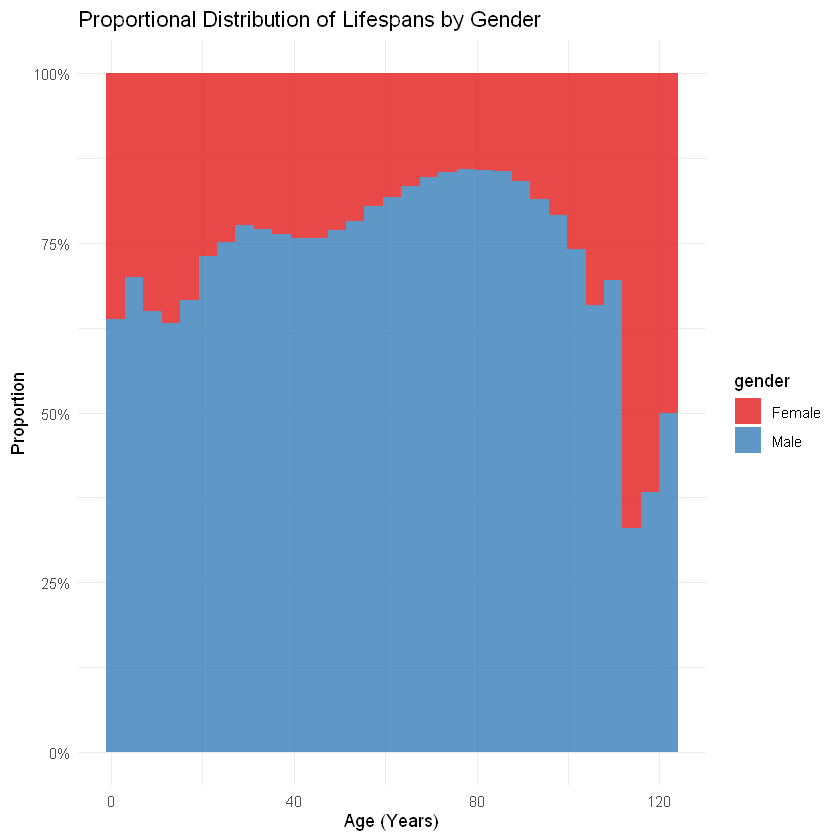

In [13]:
bhht_clean %>%
  filter(gender != "Missing", gender != "", !is.na(gender), gender != "Other") %>%
  ggplot(aes(x = survival_time_age, fill = gender)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  palette +
  labs(title = "Distribution of Lifespans by Gender", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(gender != "Missing", gender != "", !is.na(gender), gender != "Other") %>%
  ggplot(aes(x = survival_time_age, fill = gender)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by Gender",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = gender)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by Gender", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### Distribution by UN Region

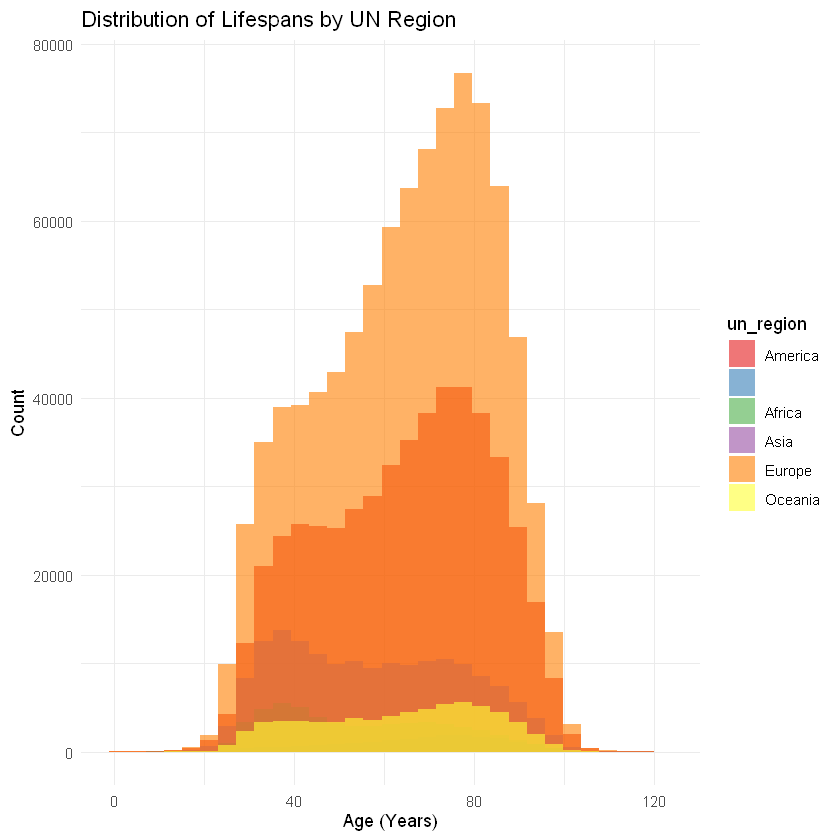

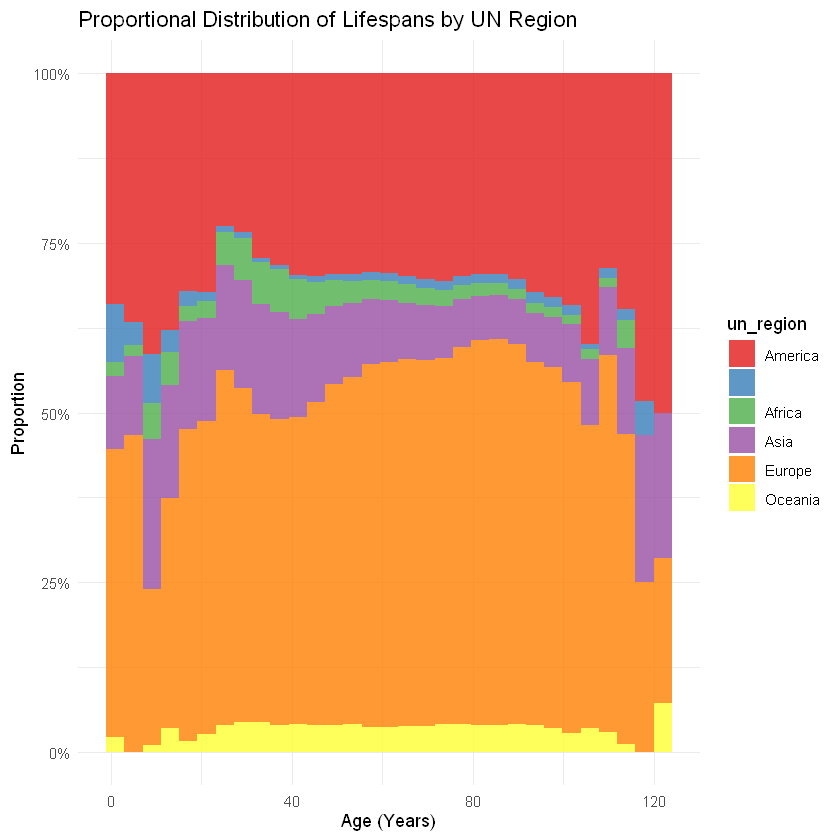

In [14]:
bhht_clean %>%
filter(un_region != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_region)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  palette +
  labs(title = "Distribution of Lifespans by UN Region", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(un_region != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_region)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by UN Region",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = un_region)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by UN Region", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### By UN Subregion

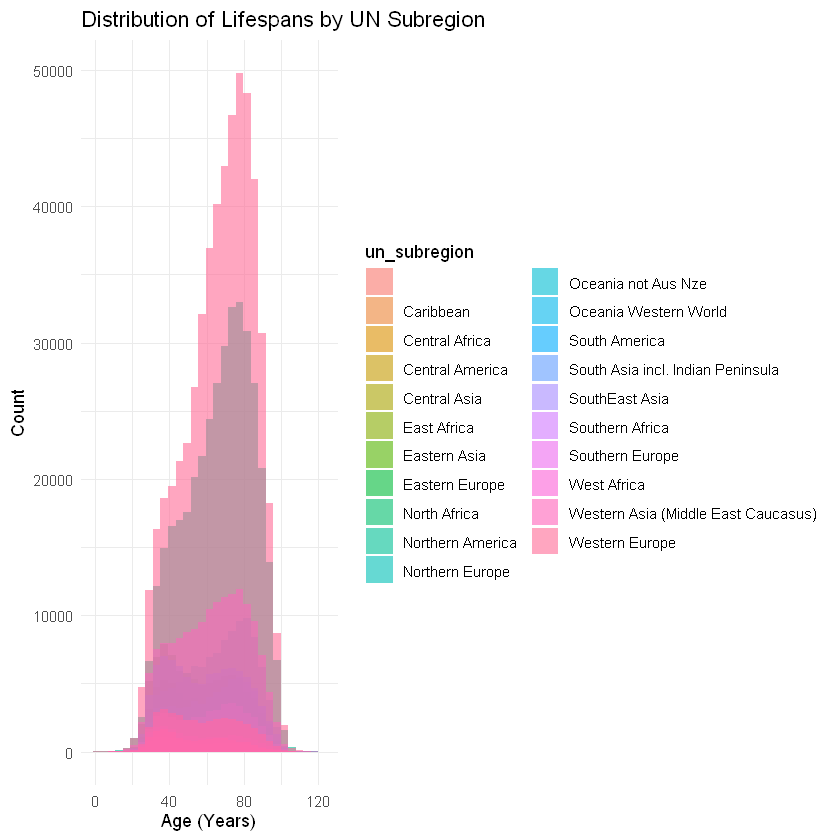

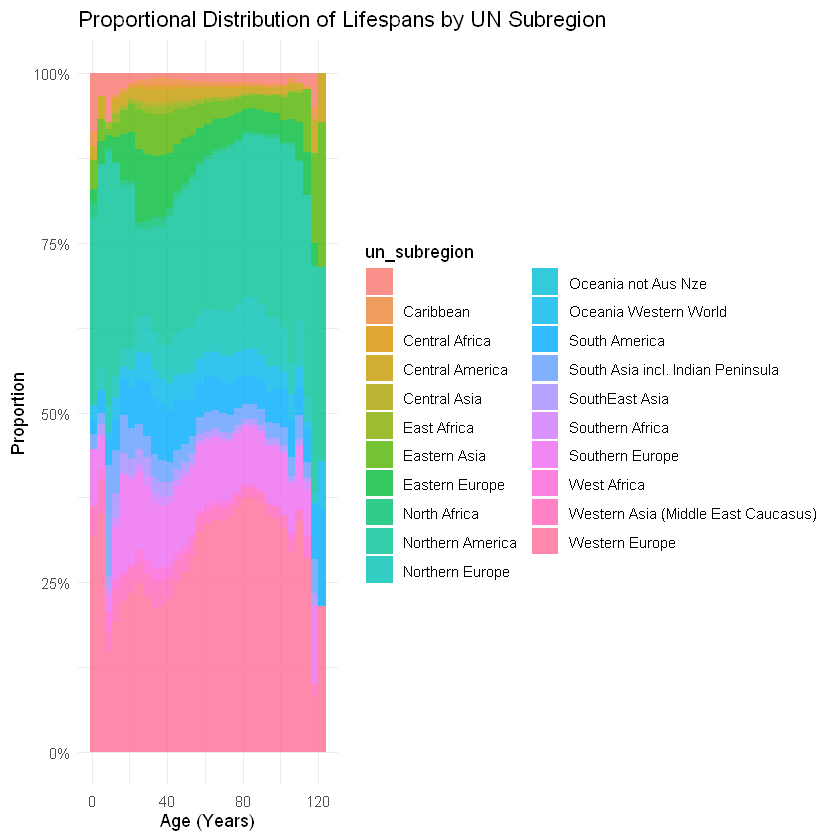

In [15]:
bhht_clean %>%
  filter(un_subregion != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_subregion)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
  # palette +
  labs(title = "Distribution of Lifespans by UN Subregion", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(un_subregion != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = un_subregion)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) +
  # palette +
  labs(
    title = "Proportional Distribution of Lifespans by UN Subregion",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()

# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = un_subregion)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by UN Subregion", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

### Distribution by L1 Occupation

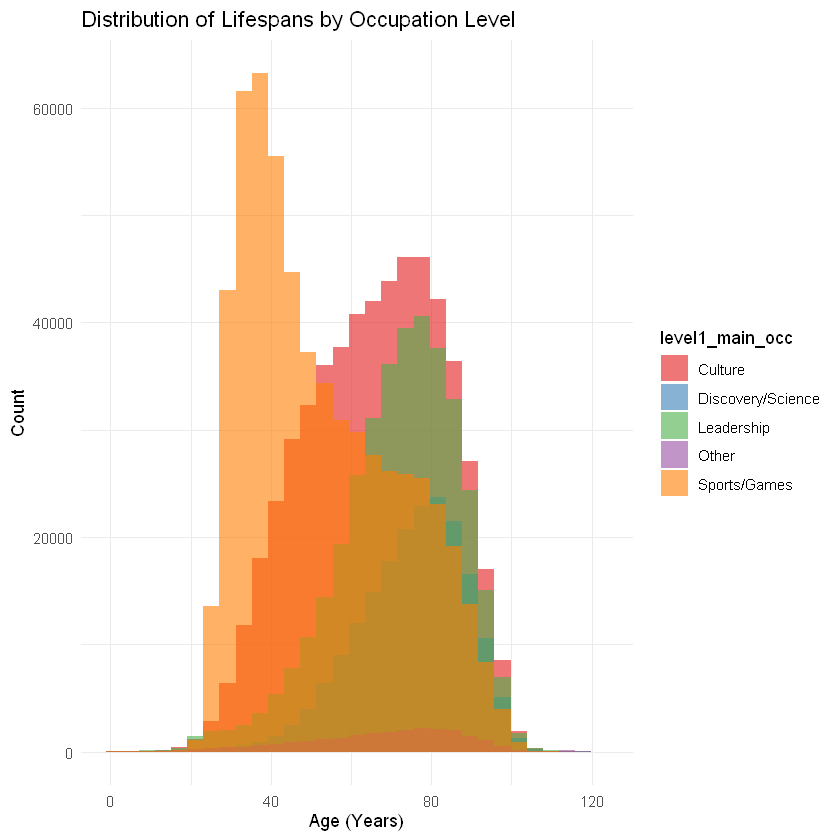

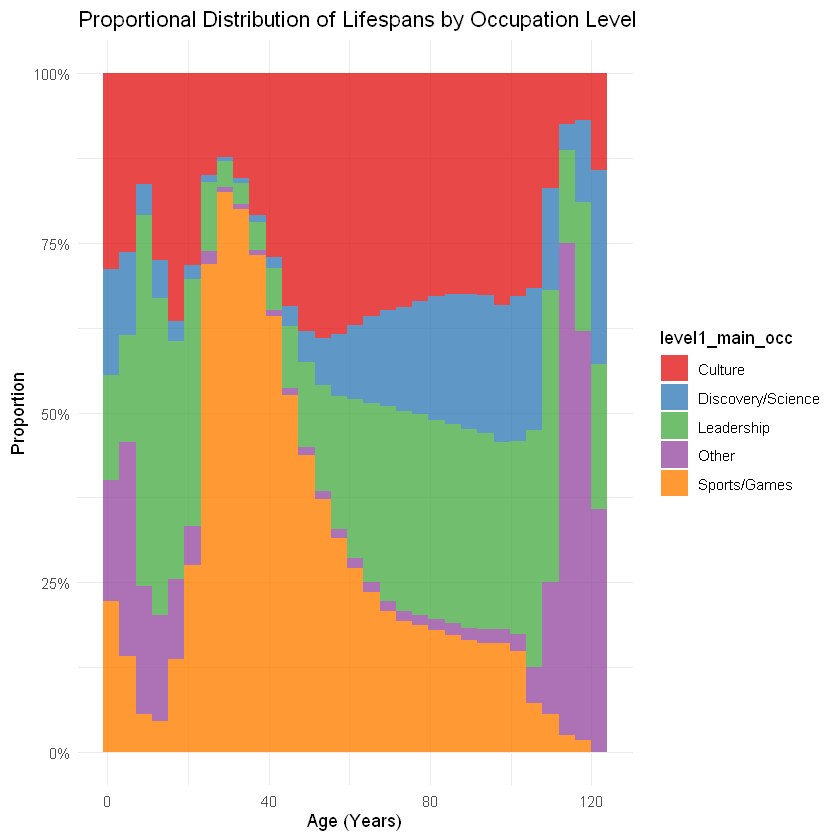

In [16]:
bhht_clean %>%
  filter(level1_main_occ != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = level1_main_occ)) +
  geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) + 
  palette +
  labs(title = "Distribution of Lifespans by Occupation Level", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  filter(level1_main_occ != "Missing") %>%
  ggplot(aes(x = survival_time_age, fill = level1_main_occ)) +
  geom_histogram(bins = num_bins, position = "fill", alpha = 0.8) + 
  palette +
  labs(
    title = "Proportional Distribution of Lifespans by Occupation Level",
    x = "Age (Years)",
    y = "Proportion"
  ) +
  scale_y_continuous(labels = scales::percent_format()) +
  theme_minimal()


# bhht_clean %>%
#   ggplot(aes(x = survival_time_year, fill = level1_main_occ)) +
#   geom_histogram(bins = num_bins, position = "identity", alpha = 0.6) +
#   labs(title = "Distribution of Lifespans by Occupation Level", x = "Years Since 1925", y = "Count") +
#   theme_minimal()

---
# Age Based Survival Analysis

## Overall

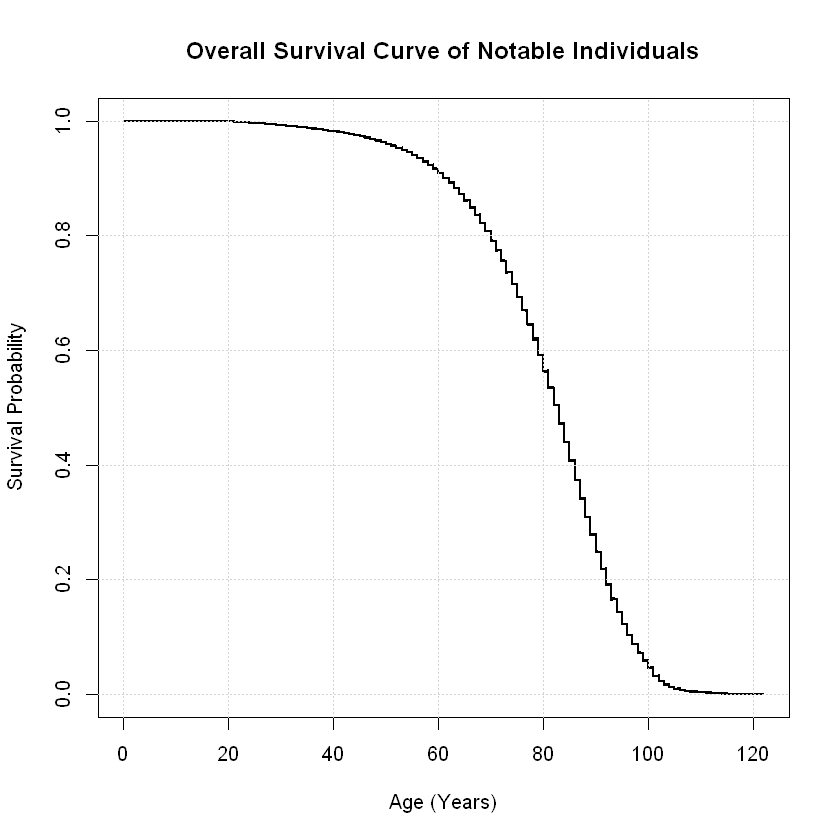

In [17]:
surv_obj <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)

km_fit <- survfit(surv_obj ~ 1, data = bhht_clean)

par(bg = 'white')
plot(km_fit,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Overall Survival Curve of Notable Individuals",
     col = "black",
     lwd = 2)
grid()

## By Gender

Call:
survdiff(formula = Surv(survival_time_age, status) ~ gender, 
    data = bhht_clean_gdr)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
gender=Female  319850    79795   111221      8879     11307
gender=Male   1405521   581616   550190      1795     11307

 Chisq= 11307  on 1 degrees of freedom, p= <2e-16 

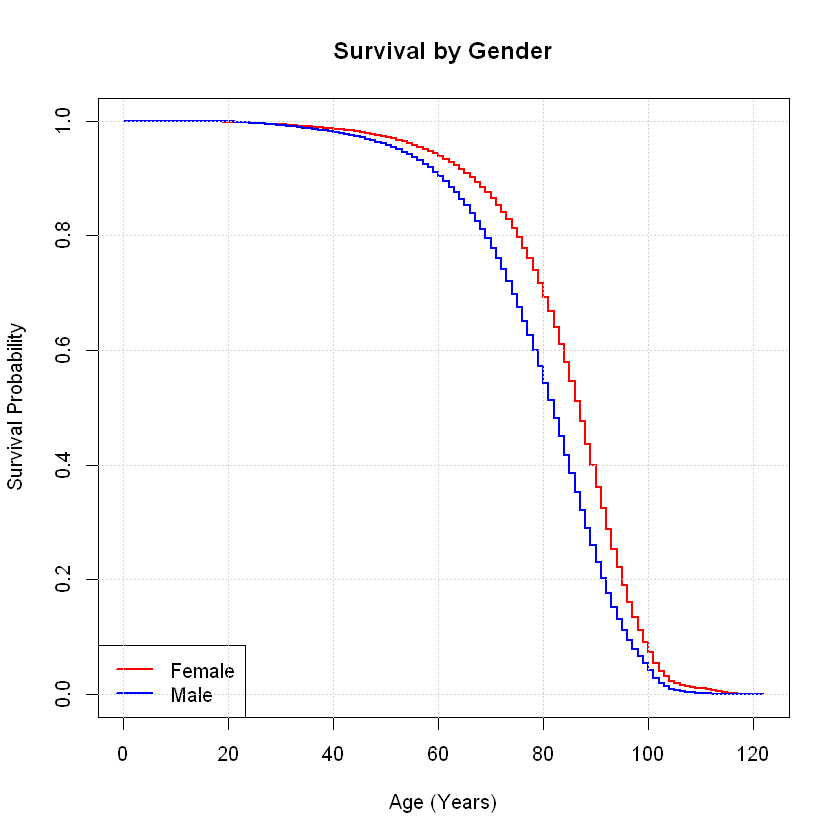

In [18]:
bhht_clean_gdr <- bhht_clean %>% filter(gender != "Other") %>% filter(!is.na(gender)) 
bhht_clean_gdr <- bhht_clean_gdr[!is.na(bhht_clean_gdr$gender) & 
                                 bhht_clean_gdr$gender != "Other" & 
                                 bhht_clean_gdr$gender != "", ]


surv_obj_age <- Surv(time = bhht_clean_gdr$survival_time_age, event = bhht_clean_gdr$status)
km_fit_gender <- survfit(surv_obj_age ~ gender, data = bhht_clean_gdr)

par(bg = 'white')
plot(km_fit_gender,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Gender",
     col = c("red", "blue"),
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_gdr$gender)),
       col = c("red", "blue"), lwd = 2)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ gender, data = bhht_clean_gdr)

Indicates that female individuals tend to live longer than their male counterparts among notable people in the past century.

## By UN Region

Warning message in `[<-.factor`(`*tmp*`, bhht_clean$un_region == "", value = "Missing"):
"invalid factor level, NA generated"


Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_region, 
    data = bhht_clean_no_missing)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
un_region=America 509541   192292   203586     626.5     956.9
un_region=Africa   55214    11263    12340      94.0      99.9
un_region=Asia    169631    41189    48482    1097.1    1244.7
un_region=Europe  904846   381579   363150     935.3    2213.2
un_region=Oceania  67852    26748    25514      59.7      65.1

 Chisq= 2955  on 4 degrees of freedom, p= <2e-16 

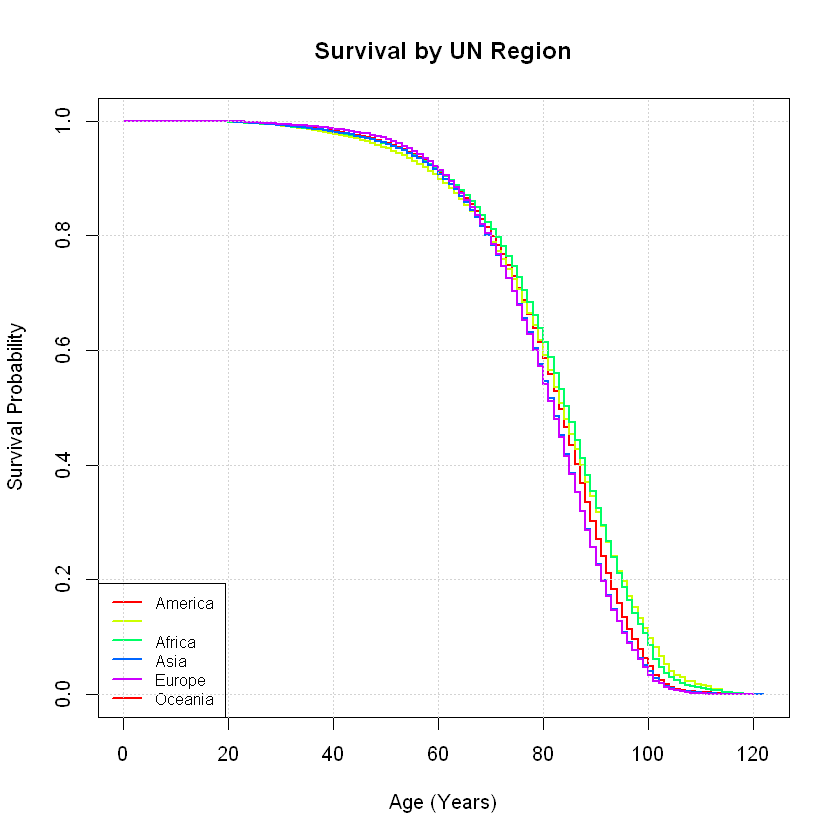

In [19]:
# Relabel missing regions
bhht_clean$un_region[bhht_clean$un_region == ""] <- "Missing"

bhht_clean_no_missing <- bhht_clean %>% filter(un_region != "Missing")

surv_obj_age <- Surv(time = bhht_clean_no_missing$survival_time_age, event = bhht_clean_no_missing$status)

km_fit_region <- survfit(surv_obj_age ~ un_region, data = bhht_clean_no_missing)

region_colors <- rainbow(length(unique(bhht_clean_no_missing$un_region)))
par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Region",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_no_missing$un_region)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_region, data = bhht_clean_no_missing)

## By UN Subregion

Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_subregion, 
    data = bhht_clean_no_missing)

                                                      N Observed Expected
un_subregion=Caribbean                            12168     3061     3434
un_subregion=Central Africa                        4948      808      851
un_subregion=Central America                      24227     6488     7237
un_subregion=Central Asia                          3750      333      405
un_subregion=East Africa                          10468     1826     2063
un_subregion=Eastern Asia                         59780    11559    15888
un_subregion=Eastern Europe                       92272    30074    24374
un_subregion=North Africa                         12393     2783     3236
un_subregion=Northern America                    378767   154609   163369
un_subregion=Northern Europe                     111901    48388    46999
un_subregion=Oceania not Aus Nze                   1611      277      234
un_

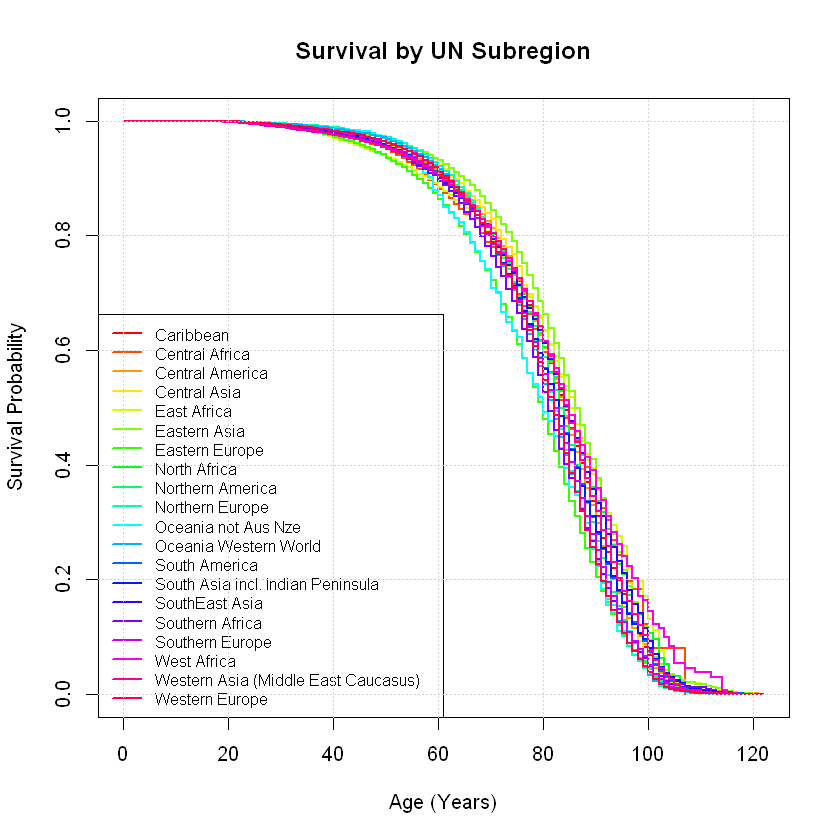

In [20]:
# Relabel missing regions
bhht_clean$un_subregion[bhht_clean$un_subregion == ""] <- "Missing"

bhht_clean_no_missing <- bhht_clean %>% filter(un_subregion != "Missing")

surv_obj_age <- Surv(time = bhht_clean_no_missing$survival_time_age, event = bhht_clean_no_missing$status)

km_fit_region <- survfit(surv_obj_age ~ un_subregion, data = bhht_clean_no_missing)

region_colors <- rainbow(length(unique(bhht_clean_no_missing$un_subregion)))
par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Subregion",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_no_missing$un_subregion)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_subregion, data = bhht_clean_no_missing)

## By L1 Occupation

Call:
survdiff(formula = Surv(survival_time_age, status) ~ level1_main_occ, 
    data = bhht_clean)

                                       N Observed Expected (O-E)^2/E (O-E)^2/V
level1_main_occ=Culture           551926   223997   218693     128.6     201.8
level1_main_occ=Discovery/Science 192549   105316   118485    1463.6    1884.1
level1_main_occ=Leadership        361761   200679   186814    1029.0    1508.5
level1_main_occ=Missing             6698     4068     3496      93.4      99.8
level1_main_occ=Other              24178    15045    12953     337.8     373.7
level1_main_occ=Sports/Games      589563   112469   121133     619.6     800.0

 Chisq= 3877  on 5 degrees of freedom, p= <2e-16 

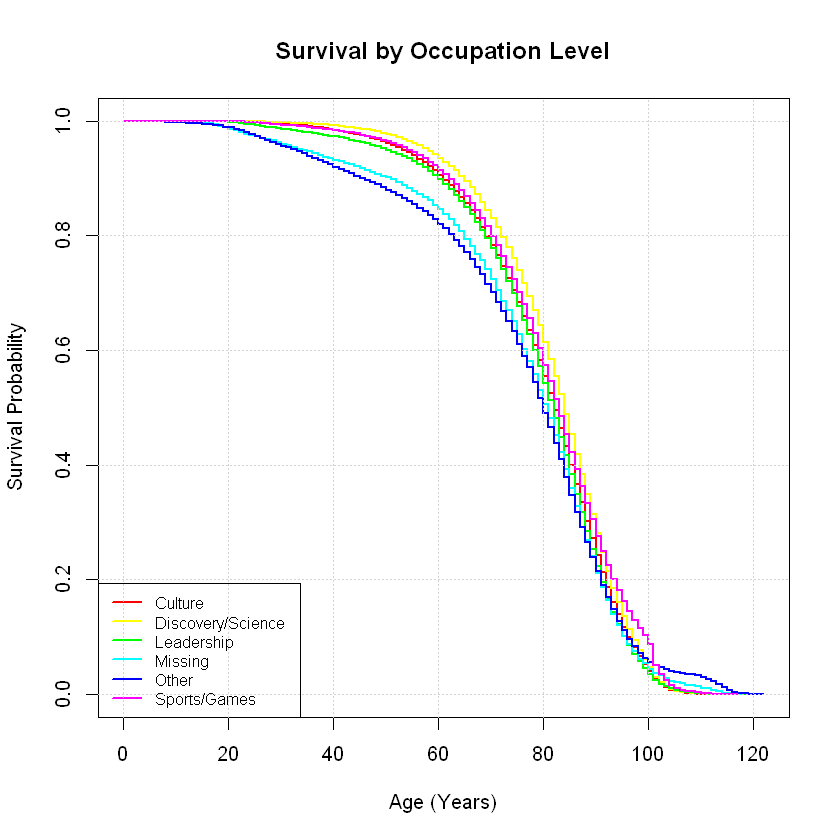

In [21]:
surv_obj_age <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)
km_fit_region <- survfit(surv_obj_age ~ level1_main_occ, data = bhht_clean)

region_colors <- rainbow(length(unique(bhht_clean$level1_main_occ)))

par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Occupation Level",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean$level1_main_occ)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ level1_main_occ, data = bhht_clean)

## `survminer` curves 
- Just visualizes the same data in ggplot for the presentation
- Can tweak more if we want to use this

Warning message:
"package 'survminer' was built under R version 4.4.3"
Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 4.4.3"

Attaching package: 'survminer'


The following object is masked from 'package:survival':

    myeloma


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>."


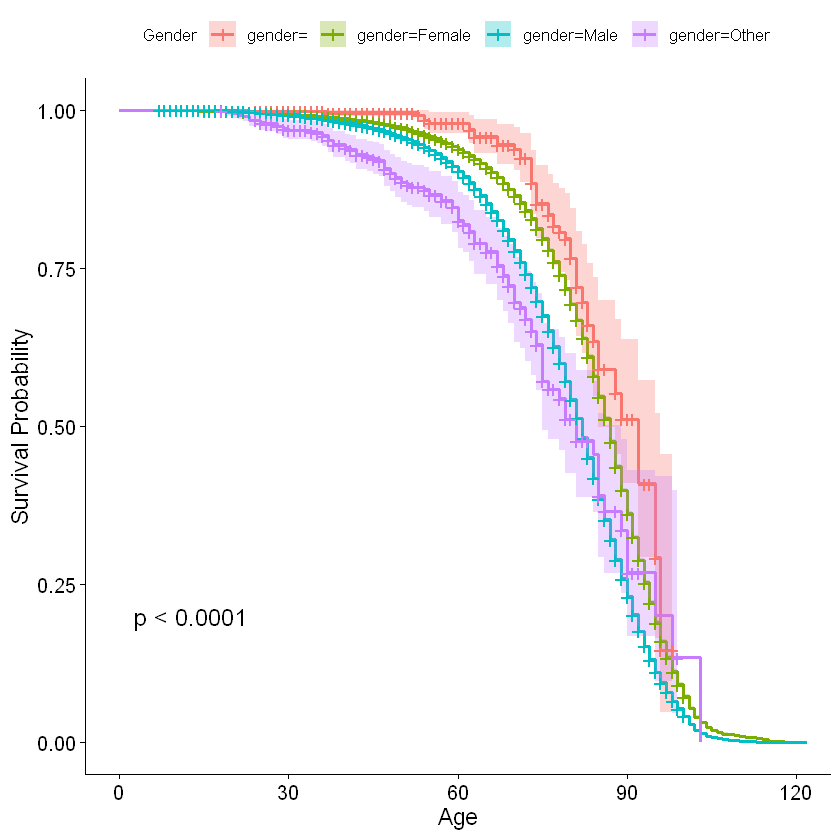

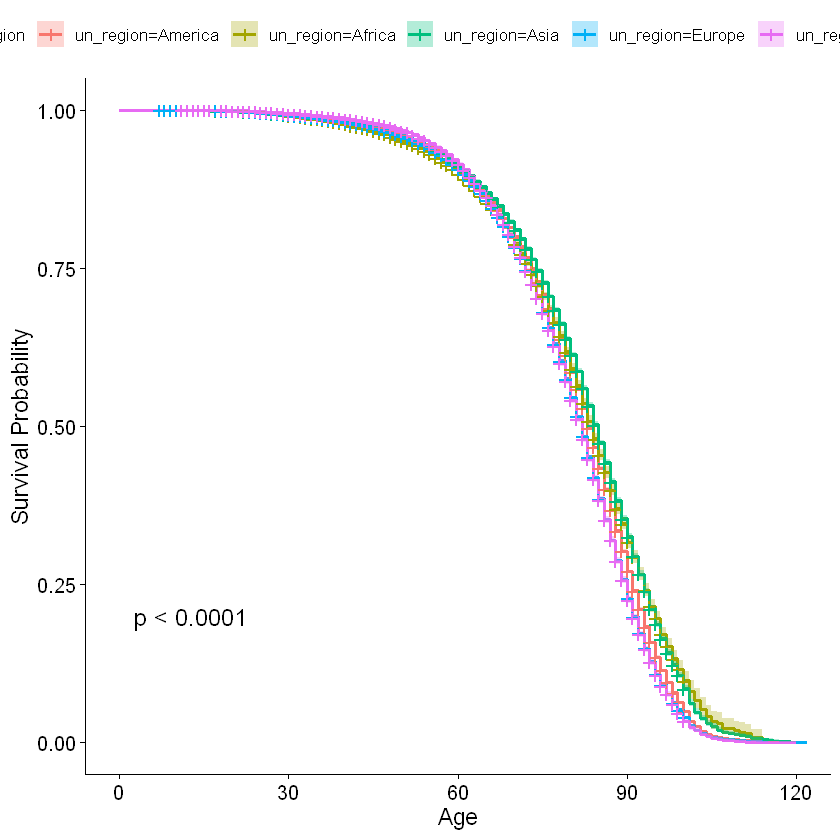

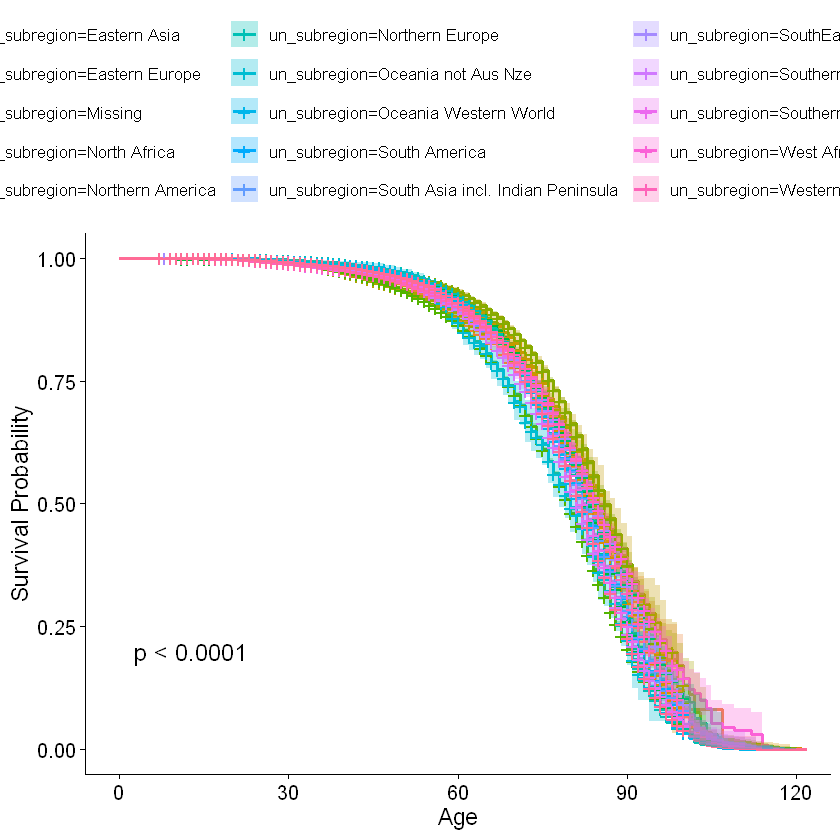

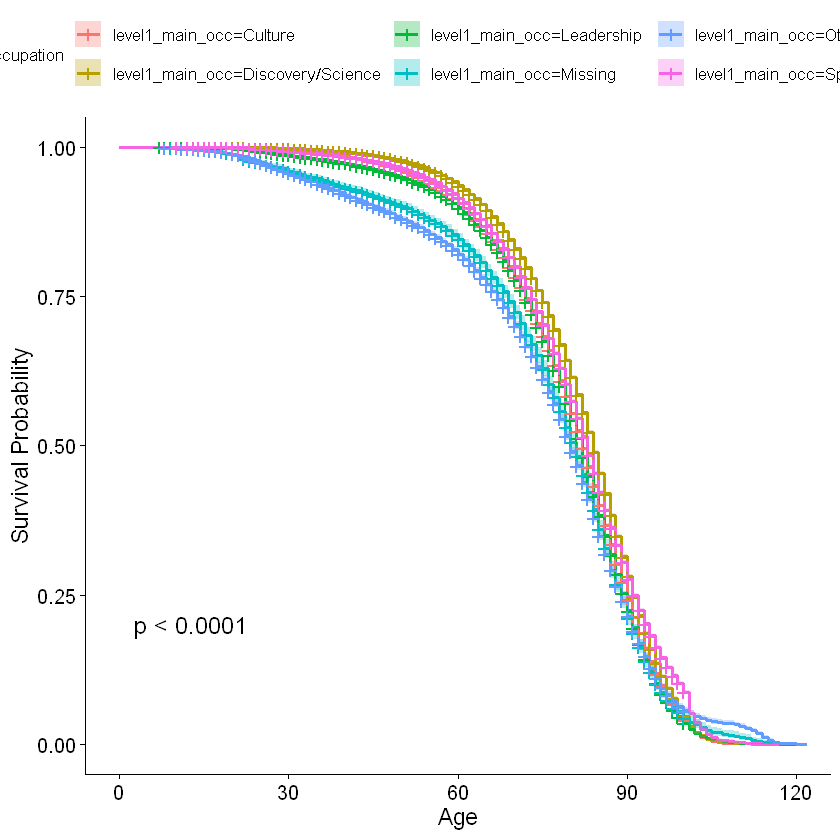

In [22]:
library(survival)
library(survminer)

# Compare survival curves across groups

km_gender <- survfit(Surv(survival_time_age, status) ~ gender, data = bhht_clean)
ggsurvplot(km_gender, conf.int = TRUE, pval = TRUE,
            legend.title = "Gender", xlab = "Age", ylab = "Survival Probability")

km_region <- survfit(Surv(survival_time_age, status) ~ un_region, data = bhht_clean)
ggsurvplot(km_region, conf.int = TRUE, pval = TRUE,
            legend.title = "Region", xlab = "Age", ylab = "Survival Probability")

km_subregion <- survfit(Surv(survival_time_age, status) ~ un_subregion, data = bhht_clean)
ggsurvplot(km_subregion, conf.int = TRUE, pval = TRUE,
            legend.title = "Subregion", xlab = "Age", ylab = "Survival Probability")

km_occupation <- survfit(Surv(survival_time_age, status) ~ level1_main_occ, data = bhht_clean)
ggsurvplot(km_occupation, conf.int = TRUE, pval = TRUE,
            legend.title = "Occupation", xlab = "Age", ylab = "Survival Probability")

---
## Cox Proportional Hazards Model

### Full Baseline Model

In [23]:
bhht_clean_filtered <- bhht_clean %>%
  mutate(
    gender = as.character(gender),
    un_region = as.character(un_region),
    level1_main_occ = as.character(level1_main_occ)
  ) %>%
  # Comment out filters if needed
  filter(
    !is.na(gender), gender != "Other", gender != "",
    !is.na(un_region), un_region != "Other", un_region != "Missing", un_region != "",
    !is.na(level1_main_occ), level1_main_occ != "Other", level1_main_occ != "Missing", level1_main_occ != ""
  ) %>%
  mutate(
    gender = factor(gender),
    un_region = factor(un_region),
    level1_main_occ = factor(level1_main_occ)
  ) %>%

  # Drop unused factor levels
  mutate(
    gender = droplevels(gender),
    un_region = droplevels(un_region),
    level1_main_occ = droplevels(level1_main_occ)
  )

levels(bhht_clean_filtered$gender)
levels(bhht_clean_filtered$un_region)
levels(bhht_clean_filtered$level1_main_occ)

[1] "Female" "Male"

[1] "Africa"  "America" "Asia"    "Europe"  "Oceania"

[1] "Culture"           "Discovery/Science" "Leadership"       
[4] "Sports/Games"

### Multivariate Cox Model

In [24]:
cox_age <- coxph(Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ, data = bhht_clean_filtered)
summary(cox_age)

Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.422968  1.526485  0.003978 106.319  < 2e-16
un_regionAmerica                  0.057090  1.058751  0.009856   5.792 6.94e-09
un_regionAsia                    -0.081234  0.921978  0.010809  -7.516 5.67e-14
un_regionEurope                   0.164939  1.179322  0.009730  16.952  < 2e-16
un_regionOceania                  0.185646  1.203996  0.011437  16.232  < 2e-16
level1_main_occDiscovery/Science -0.198909  0.819625  0.003792 -52.455  < 2e-16
level1_main_occLeadership         0.001060  1.001061  0.003147   0.337    0.736
level1_main_occSports/Games      -0.170233  0.843469  0.003751 -45.385  < 2e-16
                                    
genderMale                       ***
un_regionAmerica                 ***


                chisq df      p
gender           1604  1 <2e-16
un_region         508  4 <2e-16
level1_main_occ  1441  3 <2e-16
GLOBAL           3515  8 <2e-16


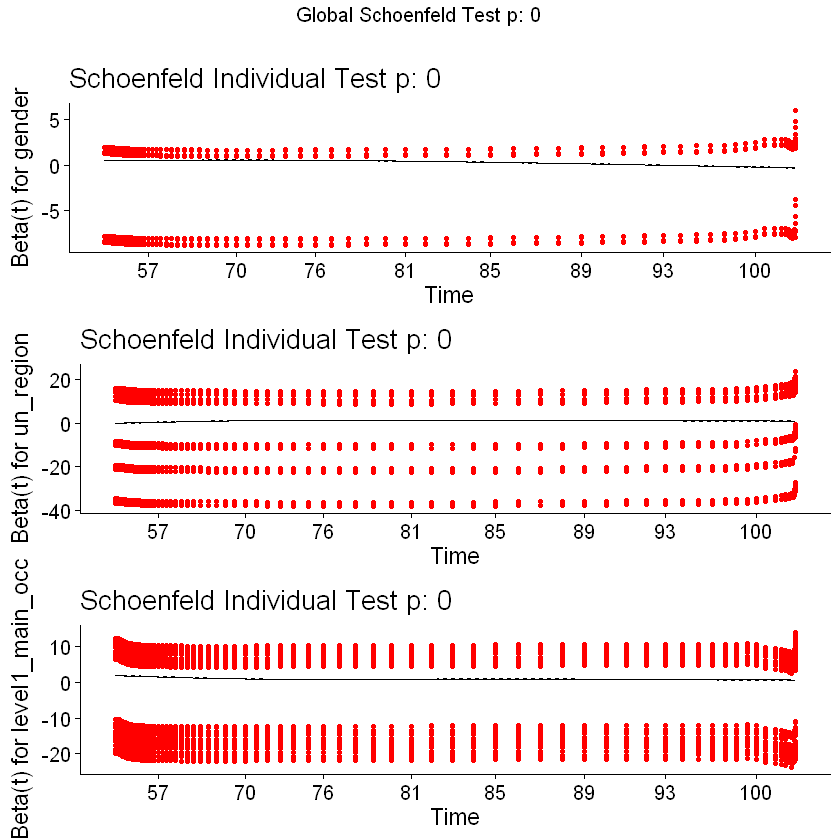

In [25]:
#### PH Diagnostics Check
ph_test <- cox.zph(cox_age)
print(ph_test)
ggcoxzph(ph_test)

- All 3 plots have clear curvature and p-values of near 0. The global test having this means the proportional hazards assumption is violated.
- The effect of gender, region, and occupation on mortality risk DO change with age.
- I think we can simply state this, and don't need to rework this to hold anything constant or stratify on covariates.
    - Okay wait adding birth_decade stabilizes this

### Multivariate Cox Model (Cohort Control)

In [26]:
cox_model <- coxph(Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ + birth_decade,
                   data = bhht_clean_filtered)

summary(cox_model)

# Exponentiate for interpretability
exp(cbind(HR = coef(cox_model), confint(cox_model)))

Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + birth_decade, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                       coef  exp(coef)   se(coef)        z
genderMale                        0.3564205  1.4282080  0.0039999   89.107
un_regionAmerica                 -0.1436028  0.8662318  0.0098709  -14.548
un_regionAsia                    -0.1408627  0.8686086  0.0108103  -13.030
un_regionEurope                  -0.1037712  0.9014315  0.0097608  -10.631
un_regionOceania                 -0.1160175  0.8904596  0.0114719  -10.113
level1_main_occDiscovery/Science -0.2497554  0.7789913  0.0037967  -65.783
level1_main_occLeadership        -0.1121544  0.8939063  0.0031750  -35.325
level1_main_occSports/Games      -0.0295310  0.9709008  0.0037868   -7.798
birth_decade                     -0.0153840  0.9847338  0.0000421 -365.422
                                 Pr(>|z|)    
genderMale          

,HR,2.5 %,97.5 %
genderMale,1.4282080,1.4170551,1.4394488
un_regionAmerica,0.8662318,0.8496342,0.8831536
un_regionAsia,0.8686086,0.8503983,0.8872089
un_regionEurope,0.9014315,0.8843502,0.9188427
un_regionOceania,0.8904596,0.8706614,0.9107080
level1_main_occDiscovery/Science,0.7789913,0.7732160,0.7848096
level1_main_occLeadership,0.8939063,0.8883609,0.8994862
level1_main_occSports/Games,0.9709008,0.9637216,0.9781336
birth_decade,0.9847338,0.9846525,0.9848150


                chisq df      p
gender            532  1 <2e-16
un_region        1209  4 <2e-16
level1_main_occ  2487  3 <2e-16
birth_decade     3718  1 <2e-16
GLOBAL           6978  9 <2e-16


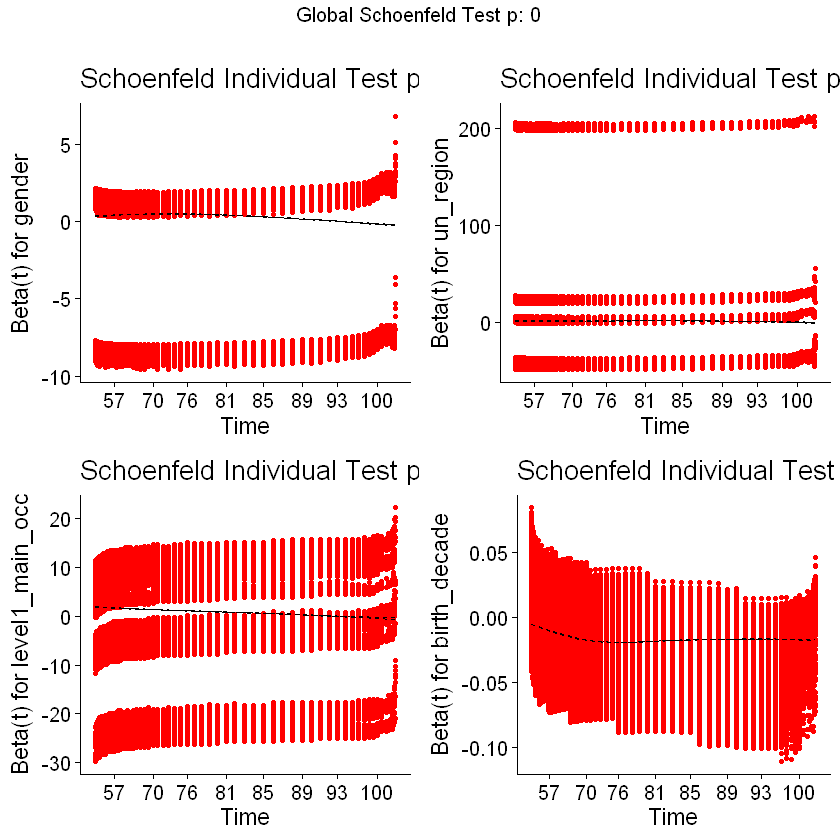

In [27]:
#### PH Diagnostics Check
ph_test <- cox.zph(cox_model)
print(ph_test)
ggcoxzph(ph_test)

- Adding `birth_decade` captures cohort effects
- All individual p-values < 0.001, every covariate has some time-dependent behavior
- Test is picking up statistically significant violations, though substantively not very significant (`birth_decade` panel shows 0.05 effect size)
- Shows only mild curvature even for our very large sample.

- If we report Hazard Ratios, have to note that they are average effects across the age range rather than fixed throughout time

### Test Interactions

#### Gender x Region
- Hypothesis: Gender norms, life expectancy, healthcare access differs by region

In [28]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * un_region + level1_main_occ, data = bhht_clean_filtered)
anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8191421,100.5192,4,7.62621e-21


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * un_region + 
    level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.350914  1.420365  0.031385  11.181  < 2e-16
un_regionAmerica                  0.028888  1.029309  0.030376   0.951  0.34161
un_regionAsia                    -0.091627  0.912445  0.033519  -2.734  0.00626
un_regionEurope                   0.076211  1.079190  0.030126   2.530  0.01141
un_regionOceania                  0.046159  1.047241  0.035624   1.296  0.19507
level1_main_occDiscovery/Science -0.199208  0.819380  0.003793 -52.525  < 2e-16
level1_main_occLeadership         0.001342  1.001343  0.003147   0.427  0.66968
level1_main_occSports/Games      -0.170158  0.843531  0.003753 -45.336  < 2e-16
genderMale:un_regionAmerica       0.029872  1.030322  0.032100   0.931  0.35207
genderMale:un_regionAsia       

- Male hazard is ~1.42× higher overall.
- Regional main effects small: slightly higher hazard in Europe/Oceania, lower in Asia.
- Significant interactions for Europe (+10%) and Oceania (+19%), meaning male disadvantage is strongest there.
- The gender gap in survival is amplified in Europe and Oceania, stable elsewhere.

#### Gender x Occupation
- Hypothesis: Occupational hazards and societal roles might differ across genders. Does this impact survival?


In [29]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * level1_main_occ + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8191010,922.538,3,1.143735e-199


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * level1_main_occ + 
    un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                 coef exp(coef)  se(coef)
genderMale                                   0.368933  1.446190  0.005273
level1_main_occDiscovery/Science            -0.138291  0.870845  0.010890
level1_main_occLeadership                   -0.117801  0.888873  0.009667
level1_main_occSports/Games                 -0.549836  0.577044  0.015547
un_regionAmerica                             0.056579  1.058210  0.009856
un_regionAsia                               -0.079440  0.923633  0.010809
un_regionEurope                              0.166798  1.181516  0.009730
un_regionOceania                             0.183462  1.201369  0.011437
genderMale:level1_main_occDiscovery/Science -0.060654  0.941148  0.011618
genderMale:level1_main_occLeadership         0.135942  1.145615  0.010224
genderMale:level1

#### Region x Occupation
- Similar logic to the last one

In [30]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ un_region * level1_main_occ + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8196283,9623.253,11,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ un_region * 
    level1_main_occ + un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                       coef exp(coef)  se(coef)
un_regionAmerica                                  -0.133152  0.875332  0.019644
un_regionAsia                                     -0.145535  0.864560  0.021020
un_regionEurope                                   -0.068711  0.933596  0.019450
un_regionOceania                                  -0.201718  0.817325  0.024877
level1_main_occDiscovery/Science                  -0.306324  0.736148  0.036477
level1_main_occLeadership                         -0.209889  0.810674  0.023717
level1_main_occSports/Games                       -0.432930  0.648606  0.029596
un_regionAmerica:level1_main_occDiscovery/Science  0.053240  1.054683  0.037213
un_regionAsia:level1_main_occDiscovery/Science    -0.007538  0.992490  0.039864
un_regionEurope:level1_main_

### Occupation x Birth Decade
- See if occupation's hazard differs significantly across cohorts

In [31]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ level1_main_occ * birth_decade + gender + un_region, data = bhht_clean_filtered)

anova(cox_age, cox_inter)
summary(cox_inter)

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8127203,128537.5,4,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ level1_main_occ * 
    birth_decade + gender + un_region, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                    coef  exp(coef)   se(coef)
level1_main_occDiscovery/Science               3.361e+00  2.882e+01  2.356e-01
level1_main_occLeadership                      2.164e-01  1.242e+00  1.909e-01
level1_main_occSports/Games                    1.341e+01  6.663e+05  2.415e-01
birth_decade                                  -1.395e-02  9.861e-01  7.186e-05
genderMale                                     3.535e-01  1.424e+00  4.003e-03
un_regionAmerica                              -1.448e-01  8.652e-01  9.880e-03
un_regionAsia                                 -1.401e-01  8.692e-01  1.081e-02
un_regionEurope                               -1.005e-01  9.044e-01  9.766e-03
un_regionOceania                              -1.303e-01  8.778e-01  1.149e-02
level1_main_occDiscovery/S

#### Region Specific Gender Nuance over Time

In [32]:
cox_inter <- coxph(Surv(survival_time_age, status) ~ gender * un_region * birth_decade + level1_main_occ, data = bhht_clean_filtered)
anova(cox_age, cox_inter)
summary(cox_inter)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  1,11,13,14,20,22 ; coefficient may be infinite. "


,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-8191472,NA,NA,NA
2,-8128781,125381,14,0


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender * un_region * 
    birth_decade + level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                               coef  exp(coef)   se(coef)
genderMale                                3.888e-01  1.475e+00  2.310e+00
un_regionAmerica                          2.215e+00  9.159e+00  2.240e+00
un_regionAsia                             7.345e+00  1.549e+03  2.472e+00
un_regionEurope                           8.316e+00  4.089e+03  2.225e+00
un_regionOceania                          5.262e+00  1.928e+02  2.491e+00
birth_decade                             -1.282e-02  9.873e-01  1.144e-03
level1_main_occDiscovery/Science         -2.491e-01  7.795e-01  3.799e-03
level1_main_occLeadership                -1.102e-01  8.957e-01  3.180e-03
level1_main_occSports/Games              -2.804e-02  9.723e-01  3.792e-03
genderMale:un_regionAmerica               1.035e+00  2.815e+00  2.351e+00
ge

---
# Calendar Year Based Survival Analysis

## Death Counts by Year

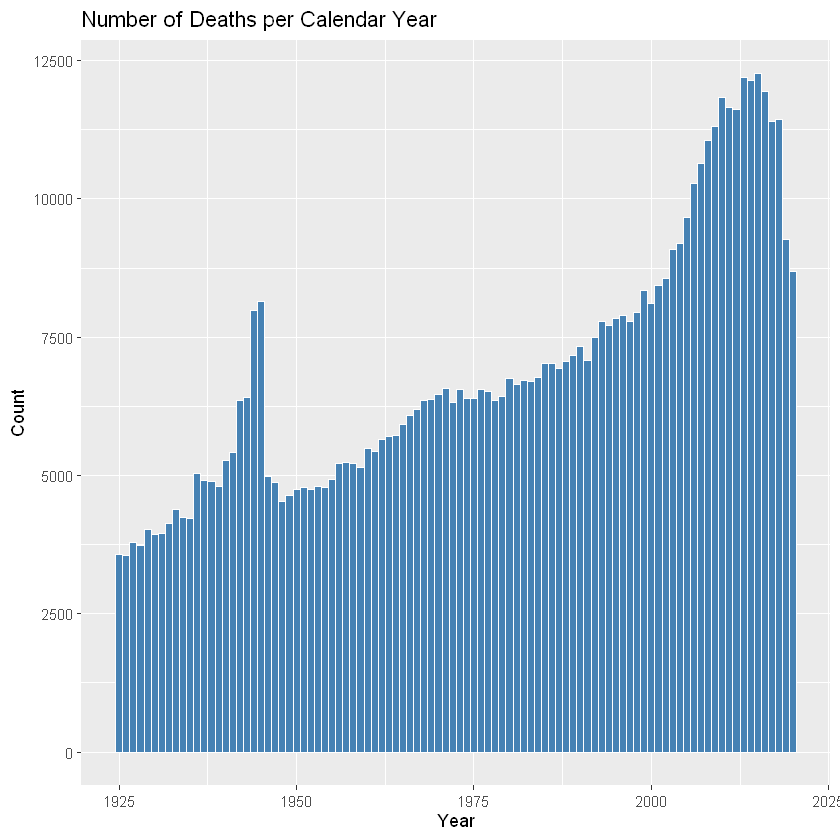

In [33]:
bhht_clean %>%
filter(status == 1) %>%
ggplot(aes(x = death_final)) +
geom_histogram(binwidth = 1, fill="steelblue", color="white") +
labs(title="Number of Deaths per Calendar Year", x="Year", y="Count")

In [34]:
death_counts <- bhht_clean %>%
    filter(status == 1) %>%
    group_by(death_final) %>%
    summarise(count = n()) %>%
    arrange(death_final)

# kable(death_counts, col.names = c("Year", "Number of Deaths"), caption = "Number of Deaths per Year")

`geom_smooth()` using formula = 'y ~ x'


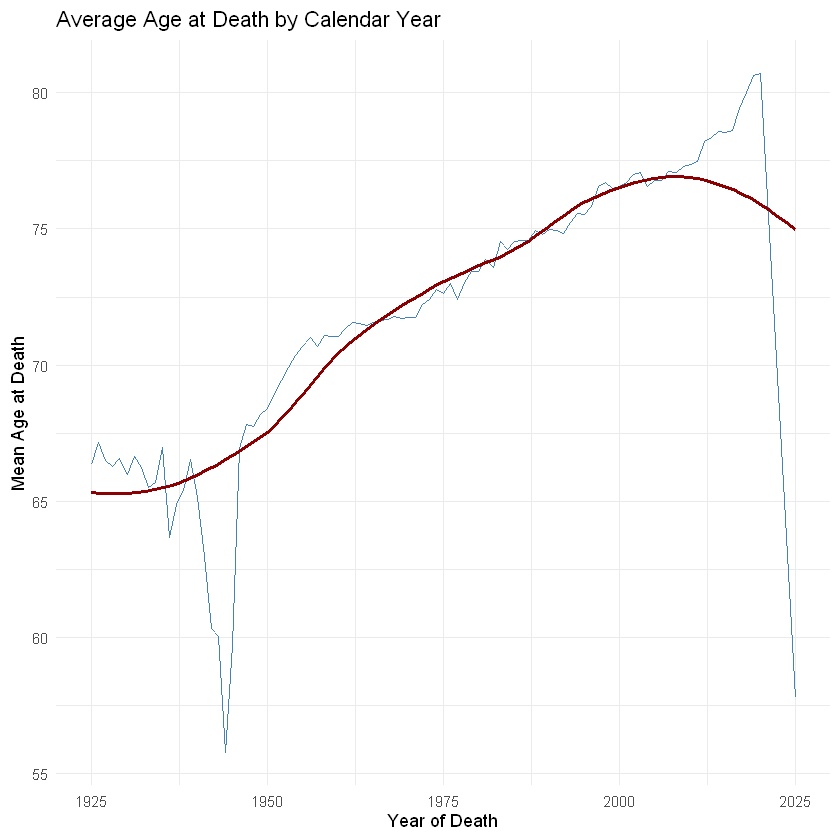

In [35]:
bhht_clean %>%
  group_by(death_final) %>%
  summarise(mean_age = mean(survival_time_age, na.rm = TRUE)) %>%
  ggplot(aes(x = death_final, y = mean_age)) +
  geom_line(color = "steelblue") +
  geom_smooth(method = "loess", color = "darkred", se = FALSE) +
  labs(
    title = "Average Age at Death by Calendar Year",
    x = "Year of Death",
    y = "Mean Age at Death"
  ) +
  theme_minimal()

- Average age of death skews sharply downward in 1940s. Likely due to war
- Average age of death rises over time. People may be healthier, higher quality of living, time of peace, etc.
- See a decrease in 2015 onward, could be related to COVID, the fact that this is likely an upper limit on maximum age for those born in the past 100 years.

## Maps of Deaths by Decade

In [36]:
plot <- FALSE

In [37]:
library(ggplot2)
library(dplyr)
library(maps)
library(viridis)

if(plot){
  # Filter and prepare data
  death_map <- bhht_clean %>%
    # Valid coordinates and death years
    filter(!is.na(dpla1), !is.na(dplo1),
          dpla1 >= -90, dpla1 <= 90,
          dplo1 >= -180, dplo1 <= 180,
          !is.na(death_final)) %>%
    mutate(decade = floor(death_final / 10) * 10) %>%
    filter(decade >= cutoff_year, decade <= current_year)

  # Load world map data
  world <- map_data("world")

  # Create output folders
  if (!dir.exists("plots")) dir.create("plots")
  if (!dir.exists("plots/total")) dir.create("plots/total")

  unique_decades <- sort(unique(death_map$decade))

  for (decade in unique_decades) {
    decade_data <- death_map %>% filter(decade == !!decade)
    
    p <- ggplot() +
      geom_polygon(
        data = world,
        aes(x = long, y = lat, group = group),
        color = "gray70", fill = "gray95", size = 0.2
      ) +
      stat_density_2d(
        data = decade_data,
        aes(x = dplo1, y = dpla1, fill = ..level.., alpha = ..level..),
        geom = "polygon", bins = 30
      ) +
      scale_fill_viridis_c(option = "plasma") +
      scale_alpha(range = c(0.2, 0.6), guide = "none") +
      coord_fixed(1.3) +
      theme_minimal() +
      labs(
        title = paste("Geographic Density of Death Locations -", decade),
        subtitle = "Notable individuals in BHHT dataset",
        x = "Longitude",
        y = "Latitude",
        fill = "Density"
      )
    
    ggsave(filename = paste0("plots/total/death_density_", decade, ".png"),
          plot = p, width = 10, height = 6, dpi = 300)
  }
}

Warning message:
"package 'maps' was built under R version 4.4.3"

Attaching package: 'maps'


The following object is masked from 'package:viridis':

    unemp


The following object is masked from 'package:purrr':

    map




In [38]:
library(dplyr)
library(ggplot2)
library(maps)
library(viridis)

if(plot){
  set.seed(42)

  death_map <- bhht_clean %>%
    filter(
      !is.na(dpla1), !is.na(dplo1),
      dpla1 >= -90, dpla1 <= 90,
      dplo1 >= -180, dplo1 <= 180,
      !is.na(death_final),
      !is.na(un_region)
    ) %>%
    mutate(decade = floor(death_final / 10) * 10) %>%
    filter(decade >= cutoff_year, decade <= current_year)

  world <- map_data("world")

  if (!dir.exists("plots")) dir.create("plots")
  if (!dir.exists("plots/regions")) dir.create("plots/regions")

  unique_decades <- sort(unique(death_map$decade))
  for (decade in unique_decades) {
    
    # Subset to current decade and calculate counts
    decade_data <- death_map %>%
      filter(decade == !!decade) %>%
      group_by(dpla1, dplo1, un_region) %>%
      summarise(count = n(), .groups = "drop") %>%
      group_by(un_region) %>%
      group_modify(~ {
        n_take <- min(10000, nrow(.x))
        dplyr::slice_sample(.x, n = n_take)
      }) %>%
      ungroup()
    
    p <- ggplot() +
      geom_polygon(
        data = world,
        aes(x = long, y = lat, group = group),
        color = "gray70", fill = "gray95", size = 0.2
      ) +
      geom_point(
        data = decade_data,
        aes(x = dplo1, y = dpla1, color = un_region, size = count),
        alpha = 0.5
      ) +
      scale_color_brewer(palette = "Set1") +
      scale_size_continuous(range = c(1, 5), guide = "legend") +
      coord_fixed(1.3) +
      theme_minimal() +
      labs(
        title = paste("Death Locations by UN Region -", decade),
        subtitle = "Point size represents the number of deaths",
        x = "Longitude",
        y = "Latitude",
        color = "UN Region",
        size = "Number of Deaths"
      )
    
    ggsave(
      filename = paste0("plots/regions/death_points_", decade, ".png"),
      plot = p,
      width = 10,
      height = 6,
      dpi = 300
    )
    
    message("Saved plot for decade ", decade)
  }
}

- Points are colored by the birthplace of the individual, and may be somewhat interesting trying to see if people migrate from their birthplace. 
- Honestly it's been really difficult trying to perform surv analysis on the calendar year lol

---
# Stratification for Rachael

## Stratify by Birth Decade
- I believe this is the most correct route forward?

In [39]:
cox_strat <- coxph(
  Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ + 
    strata(birth_decade),
  data = bhht_clean_filtered
)

summary(cox_strat)


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + strata(birth_decade), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.365747  1.441591  0.004009  91.227  < 2e-16
un_regionAmerica                 -0.205052  0.814605  0.009880 -20.755  < 2e-16
un_regionAsia                    -0.192475  0.824915  0.010817 -17.794  < 2e-16
un_regionEurope                  -0.164801  0.848062  0.009766 -16.874  < 2e-16
un_regionOceania                 -0.178392  0.836614  0.011483 -15.535  < 2e-16
level1_main_occDiscovery/Science -0.232666  0.792419  0.003797 -61.272  < 2e-16
level1_main_occLeadership        -0.086151  0.917455  0.003171 -27.167  < 2e-16
level1_main_occSports/Games      -0.018497  0.981673  0.003803  -4.864 1.15e-06
                                    
genderMale                       ***
un_regionAmeri

## Stratify by Gender
- From what I can tell from those Schoenfeld plots, this is not the correct analysis as gender isn't the problematic variable, birth_decade is.
- Stratifying by gender also means we lose out on the ability to calculate a HR for gender specifically.

In [41]:
cox_strat <- coxph(
  Surv(survival_time_age, status) ~ strata(gender) + un_region + level1_main_occ,
  data = bhht_clean_filtered
)

summary(cox_strat)

Call:
coxph(formula = Surv(survival_time_age, status) ~ strata(gender) + 
    un_region + level1_main_occ, data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
un_regionAmerica                  0.056663  1.058299  0.009856   5.749 8.98e-09
un_regionAsia                    -0.080202  0.922930  0.010809  -7.420 1.17e-13
un_regionEurope                   0.164099  1.178331  0.009730  16.866  < 2e-16
un_regionOceania                  0.184953  1.203162  0.011437  16.171  < 2e-16
level1_main_occDiscovery/Science -0.197497  0.820783  0.003792 -52.082  < 2e-16
level1_main_occLeadership         0.002634  1.002637  0.003148   0.837    0.403
level1_main_occSports/Games      -0.169882  0.843764  0.003751 -45.285  < 2e-16
                                    
un_regionAmerica                 ***
un_regionAsia                    ***
un_regionEurope                  ***
un_regionOceania                 **

## Time Dependent Covariates
- Add a time-interaction to see if gender's effect changes with log time

Potential Issues?
- These coefficients are massive (100x magnitude)
- Model is numerically unstable
- This is trying to fix the PH violation through gender, which is not where the violation is
    - But since birth_decade/survival_time_age aren't technically continuous, I'm unsure if we can use them here
- Concordance almost seems TOO high now?

In [42]:
cox_tdc <- coxph(
  Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ +
    gender:log(survival_time_age),
  data = bhht_clean_filtered
)

summary(cox_tdc)

Warning message in coxph(Surv(survival_time_age, status) ~ gender + un_region + :
"a variable appears on both the left and right sides of the formula"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Ran out of iterations and did not converge"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"one or more coefficients may be infinite"


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + gender:log(survival_time_age), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                          coef  exp(coef)   se(coef)          z
genderMale                           2.389e+00  1.090e+01  3.697e-03     646.21
un_regionAmerica                     4.199e-01  1.522e+00  2.755e-03     152.39
un_regionAsia                        7.220e-02  1.075e+00  5.198e-03      13.89
un_regionEurope                      5.436e-01  1.722e+00  2.551e-03     213.08
un_regionOceania                     6.341e-01  1.885e+00  6.347e-03      99.92
level1_main_occDiscovery/Science     4.496e-02  1.046e+00  3.437e-03      13.08
level1_main_occLeadership            1.669e-01  1.182e+00  2.751e-03      60.69
level1_main_occSports/Games         -5.596e-01  5.714e-01  3.543e-03    -157.98
genderFemale:log(survival_time_age) -1.703e+02  1.148e-74  8.675e-04 -196265.24

## Multiple Time Interactions
- This model is unstable
- Interactions make no sense due to instability
    - Men have 319x higher hazard than baseline

- Disagrees with Schoenfeld
    - We saw before birth_decade is a known violation of proportional hazards assumption. This model is forcing additional interactions with time (gender, region, occ)

In [43]:
cox_full_tdc <- coxph(
  Surv(survival_time_age, status) ~ 
    gender + un_region + level1_main_occ +
    gender:log(survival_time_age) +
    un_region:log(survival_time_age) +
    level1_main_occ:log(survival_time_age),
  data = bhht_clean_filtered
)

summary(cox_full_tdc)


Warning message in coxph(Surv(survival_time_age, status) ~ gender + un_region + :
"a variable appears on both the left and right sides of the formula"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Ran out of iterations and did not converge"
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"one or more coefficients may be infinite"


Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ + gender:log(survival_time_age) + un_region:log(survival_time_age) + 
    level1_main_occ:log(survival_time_age), data = bhht_clean_filtered)

  n= 1676602, number of events= 634850 

                                                              coef  exp(coef)
genderMale                                               5.766e+00  3.192e+02
un_regionAmerica                                        -1.266e+00  2.819e-01
un_regionAsia                                           -2.626e+00  7.238e-02
un_regionEurope                                         -8.798e-01  4.149e-01
un_regionOceania                                        -8.650e-01  4.210e-01
level1_main_occDiscovery/Science                         4.538e+00  9.349e+01
level1_main_occLeadership                                3.910e+00  4.990e+01
level1_main_occSports/Games                             -2.362e+00  9.426e-02
genderFemale:log